The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

**Root Mean Squared Error (RMSE)**

Submissions are scored on the root mean squared error. RMSE is defined as:

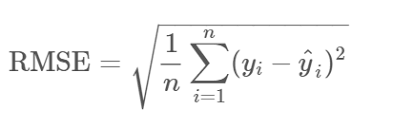

where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

**Objective**

To analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer.

**Data Set Overview**

fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

channelGrouping - The channel via which the user came to the Store.

date - The date on which the user visited the Store.

device - The specifications for the device used to access the Store.

geoNetwork - This section contains information about the geography of the user.

sessionId - A unique identifier for this visit to the store.

socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

totals - This section contains aggregate values across the session.

trafficSource - This section contains information about the Traffic Source from which the session originated.

visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

visitNumber - The session number for this user. If this is the first session, then this is set to 1.

visitStartTime - The timestamp (expressed as POSIX time).

In [2]:
!pip install plotly

     |████████████████████████████████| 23.9 MB 5.1 MB/s eta 0:00:01


In [1]:
#importing the required libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
#reference: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
#https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html
#we can convert all the json fields in the file to a flattened csv format

#function which converts the json data into a flatten csv
def load_df(csv_path='input/train.csv', nrows=None):
    '''This function returns the csv format'''
    #json format feilds in the data set are
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    #storing the data frame in variable df
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    df = pd.read_csv(csv_path,                                                   
                     converters={column: json.loads for column in JSON_COLUMNS},  #converters: dict, optional. Dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     dtype={'fullVisitorId': 'str'},                              #Data type for data or columns. E.g. {‘a’: np.float64, ‘b’: np.int32, ‘c’: ‘Int64’} Use str or object together with suitable na_values settings to preserve and not interpret dtype. If converters are specified, they will be applied INSTEAD of dtype conversion.
                     nrows=nrows)                                                 #Number of rows of file to read. Useful for reading pieces of large files.
    
    for column in JSON_COLUMNS:                         #for each column in json_coloumns                                                        
        column_as_df = pd.json_normalize(df[column])    #Normalize semi-structured JSON data into a flat table
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]      #making key value pairs of columns and subcolumns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)         #drop the not joined columns

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")     #pruints the shape of the dataframe or table
    return df                                                            #returns the dataframe

In [ ]:
%%time
#flatten the train data set and storing in train_df variable
train_df = load_df()

#flatten the test data set and storing in test_df variable
test_df = load_df("input/test.csv")

Loaded train.csv. Shape: (903653, 55)


In [ ]:
# train_df.to_csv("input/train_df.csv")
# test_df.to_csv("input/test_df.csv")

In [ ]:
train_df.head()

Traget Variable or Class Variable

In [ ]:
#converting target variables to float data type
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

#Since we are predicting the natural log of sum of all transactions of the user, 
#let us sum up the transaction revenue at user level and take a log and then do a scatter plot.
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [ ]:
#scatterplot to understand each user vs transactions
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

### Observation
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. 
As such, marketing teams are challenged to make appropriate investments in promotional strategies.

In [ ]:
#to store Number of instances in train set with non-zero revenue
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()

#to store Number of unique customers with non-zero revenue
nzr = (gdf["totals.transactionRevenue"]>0).sum()

In [ ]:
#to check Number of instances in train set with non-zero revenue
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])

#to check Number of unique customers with non-zero revenue
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

In [ ]:
#to check Number of unique visitors in train data set
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])

#to check Number of unique visitors in test set
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])

#to check Number of common visitors in train and test set
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Constant values Columns

In [ ]:
#https://pandas.pydata.org/docs/reference/api/pandas.Series.nunique.html
#Return number of unique elements in the object.
#Excludes NA values by default
#Looks like there are quite a few features with constant value in the train set. 
#Let us get the list of these features. 
#Let us not include the columns which has constant value and some null values.

const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]

In [ ]:
const_cols

They are quite a few. Since the values are constant, we can just drop them from our feature list and save some memory and time in our modeling process

## 1. Devices EDA 

In [ ]:
#A plotly.graph_objects.Bar trace is a graph object in the figure's data list with any of the named arguments or attributes listed below.
#The data visualized by the span of the bars is set in `y` if `orientation` is set th "v" (the default) and the labels are set in `x`. 
#By setting `orientation` to "h", the roles are interchanged.

def horizontal_bar_chart(cnt_srs, color):
    '''This function returns the horizonal bar charts'''
    trace = go.Bar(y=cnt_srs.index[::-1],
                   x=cnt_srs.values[::-1],
                   showlegend=False,
                   orientation = 'h',
                   marker=dict(color=color,),)
    return trace

### 1.1 Device Browser

In [ ]:
#https://pandas.pydata.org/pandas-docs/version/0.21.0/generated/pandas.DataFrame.groupby.html
#https://plotly.com/python/horizontal-bar-charts/#horizontal-bar-chart-with-gobar
#Group series using mapper (dict or key function, apply given function to group, return result as series) or by a series of columns.
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html

cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])   #Aggregate using callable, string, dict, or list of string/callables
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"] #The column labels of the DataFrame.
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

### 1.2 Device Category

In [ ]:
#https://pandas.pydata.org/pandas-docs/version/0.21.0/generated/pandas.DataFrame.groupby.html
#https://plotly.com/python/horizontal-bar-charts/#horizontal-bar-chart-with-gobar
#Group series using mapper (dict or key function, apply given function to group, return result as series) or by a series of columns.
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html

cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

### 1.3 Operating system

In [ ]:
#https://pandas.pydata.org/pandas-docs/version/0.21.0/generated/pandas.DataFrame.groupby.html
#https://plotly.com/python/horizontal-bar-charts/#horizontal-bar-chart-with-gobar
#Group series using mapper (dict or key function, apply given function to group, return result as series) or by a series of columns.
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html

cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

### 1.4 Creating two subplots

In [ ]:
#https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
#Return an instance of plotly.graph_objects.Figure with predefined subplots configured in ‘layout’.

fig = subplots.make_subplots(rows=3,
                             cols=3,
                             vertical_spacing=0.04, 
                             subplot_titles=["Device Browser - Count", 
                                             "Device Browser - Non-zero Revenue Count", 
                                             "Device Browser - Mean Revenue",
                                             "Device Category - Count",  
                                             "Device Category - Non-zero Revenue Count", 
                                             "Device Category - Mean Revenue", 
                                             "Device OS - Count", 
                                             "Device OS - Non-zero Revenue Count", 
                                             "Device OS - Mean Revenue"])

In [ ]:
#https://www.kite.com/python/docs/plotly.basedatatypes.BaseFigure.append_trace
#Add a data traces to your figure bound to axes at the row, col index. 
#The row, col index is generated from figures created with plotly.tools.make_subplots and can be viewed with Figure.print_grid.

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

### Observations
1.  Device browser distribution looks similar on both the count and count of non-zero revenue plots. But the average or mean Firefox is leading. And most of the users uses Chrome browser
2.  On the device category between desktop, mobile and tablet, desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices and tablet devices.
3.  In device operating system, though the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh. So the distribution not same in count and non-zero count.
4.  Chrome OS also has higher percentage of non-zero revenue counts
5.  On the mobile OS side, iOS has more percentage of non-zero revenue counts compared to Android.
6.  On the mobile OS side, Android has more percentage of count comapared to ios.

## 2. Exploration of Date Data

In [ ]:
#https://plotly.com/python/line-and-scatter/
#https://plotly.com/python/marker-style/
#With px.scatter, each data point is represented as a marker point, whose location is given by the x and y columns.

import datetime

def scatter_plot(cnt_srs, color):
    '''This function returns the scatter, each data point is represented as a marker point, whose location is given by the x and y columns'''
    trace = go.Scatter(x=cnt_srs.index[::-1],
                       y=cnt_srs.values[::-1],
                       showlegend=False,
                       marker=dict(color=color,),)
    return trace

In [ ]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [ ]:
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

In [ ]:
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

In [ ]:
fig = subplots.make_subplots(rows=2, 
                             cols=1, 
                             vertical_spacing=0.08,
                             subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

### Observations
1.  We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
2.  In Nov 2016, though there is an increase in the count of visitors, there is no increase in non-zero revenue counts during that time period (relative to the mean).
3.  The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

## 3. Test Data Explore

In [ ]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [ ]:
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()

In [ ]:
#https://plotly.com/r/line-and-scatter/

trace = scatter_plot(cnt_srs, 'red')

In [ ]:
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Layout.html

layout = go.Layout(height=400,
                   width=800,
                   paper_bgcolor='rgb(233,233,233)',
                   title='Dates in Test set')

In [ ]:
#https://plotly.com/python/creating-and-updating-figures/
#Graph object constructors and update methods accept "magic underscores" (e.g. go.Figure(layout_title_text="The Title") rather than dict(layout=dict(title=dict(text="The Title")))) for more compact code, as described below.

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

### Onservations
1.  In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018. So there are no common dates between train and test set. 
2.  So it might be a good idea to do time based validation for this dataset.

## 4. Exploration of Geographic Information Data

### 4.1 Continent Data

In [ ]:
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

### 4.2 Sub-continent

In [ ]:
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

### 4.3 Network domain

In [ ]:
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

### 4.4 Creating two subplots

In [ ]:
fig = tools.make_subplots(rows=3, 
                          cols=3, 
                          vertical_spacing=0.08, 
                          horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", 
                                          "Continent - Non-zero Revenue Count", 
                                          "Continent - Mean Revenue",
                                          "Sub Continent - Count",  
                                          "Sub Continent - Non-zero Revenue Count", 
                                          "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", 
                                          "Network Domain - Non-zero Revenue Count", 
                                          "Network Domain - Mean Revenue"])

In [ ]:
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

### Observations
1.  On the continent plot, we can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
2.  Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.
3.  We can infer the first two points from the sub-continents plot too.
4.  If the network domain is "unknown.unknown" rather than "(not set)", then the number of counts with non-zero revenue tend to be lower.
5. On the subcontinent plot, we can see that North America has both higher number of counts as well as highest number of counts where the revenue is non-zero

## 5. Exploration of Traffic Source Data

### 5.1 Continent

In [ ]:
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

### 5.2 Sub-continent

In [ ]:
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

### 5.3 Creating two subplots

In [ ]:
fig = tools.make_subplots(rows=2, 
                          cols=3, 
                          vertical_spacing=0.08, 
                          horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", 
                                          "Traffic Source - Non-zero Revenue Count", 
                                          "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  
                                          "Traffic Source Medium - Non-zero Revenue Count", 
                                          "Traffic Source Medium - Mean Revenue"])

In [ ]:
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

### Observations
1.  In the traffic source plot, though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
2.  Google plex has a high ratio of non-zero revenue count to total count in the traffic source plot.
3.  On the traffic source medium, "referral" has more number of non-zero revenue count compared to "organic" medium.

## 6. Exploration of Visitor Profile data

### 6.1 Page views

In [ ]:
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

### 6.2 Hits

In [ ]:
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

In [ ]:
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

### 6.3 Creating two subplots

In [ ]:
fig = tools.make_subplots(rows=2, 
                          cols=3, 
                          vertical_spacing=0.08, 
                          horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", 
                                          "Total Pageviews - Non-zero Revenue Count", 
                                          "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  
                                          "Total Hits - Non-zero Revenue Count", 
                                          "Total Hits - Mean Revenue"])

In [ ]:
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

### Observations
1.  Both these variables look very predictive
2.  Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor 3.  transaction and the overall count decreases when the number of hits per visitor transaction increases.
4.  On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts.